In [1]:
import jax
from jax import jit
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device",jax.devices()[3])
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})


# from KernelTools import *
from parabolic_data_utils import (
    build_burgers_data,
    build_tx_grid_chebyshev,
    GP_Sampler_1D_Pinned,
    setup_problem_data
)
# from plotting import plot_input_data

from KernelTools import diagpart

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
k = 5e-4
kappa = 0.01
alpha = 0.5
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0

u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:03<00:00, 2964.53it/s]


## Compute collocation points, insert sample points

In [3]:
num_grid_x = 26
num_grid_t = 26

#Build a collocation grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.6)

tx_all = jnp.vstack([tx_bdy,tx_int])

#Observe on initial+final+boundary
init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)
final_obs_inds = jnp.where(tx_int[:,0]==1)[0][::1]
u_true = u_true_function(tx_all)

x_t_sample_inds = jnp.hstack([init_obs_inds,final_obs_inds])
tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])
u_obs = u_true_function(tx_obs)


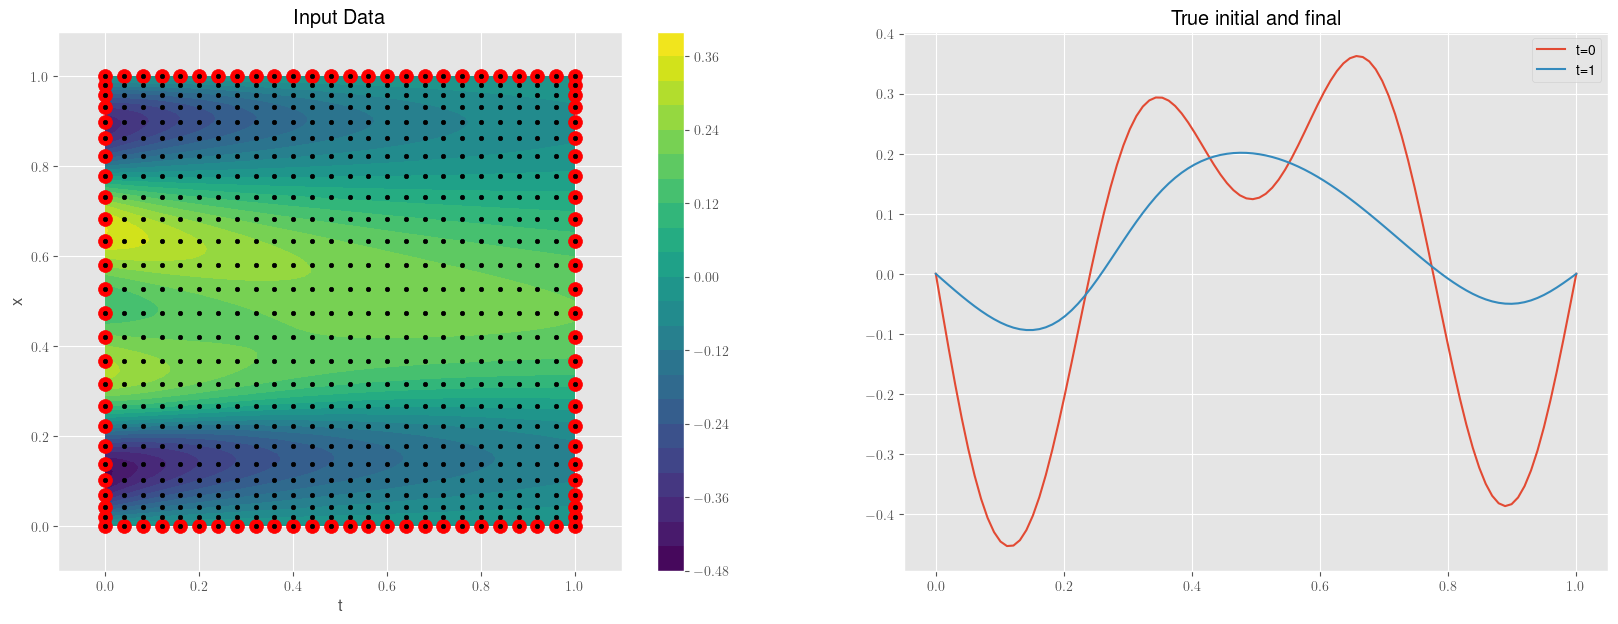

In [4]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 10)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

plt.subplot(1,2,2)
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()

## Setup model

In [5]:
from EquationModel import CholInducedRKHS, OperatorPDEModel,OperatorModel
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_gaussianRBF,
    get_anisotropic_gaussianRBF
)
from KernelTools import eval_k,dx_k,dxx_k,dt_k


u_operators = (eval_k,dx_k,dt_k,dxx_k)
# u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

#k_u = get_gaussianRBF(jnp.sqrt(0.025/2))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,100])))

u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

from KernelTools import vectorize_kfunc
@vectorize_kfunc
def k_P(x,y):
    return 10*k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

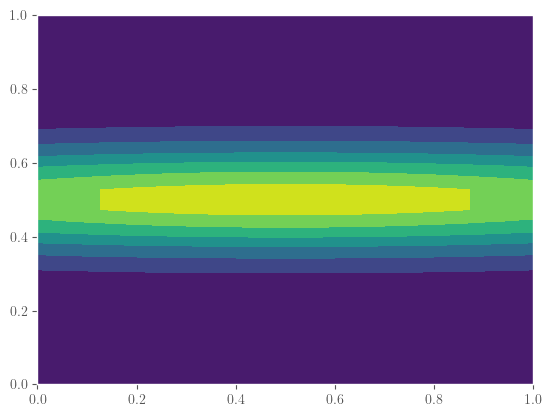

In [6]:
plt.tricontourf(tx_all[:,0],tx_all[:,1],vectorize_kfunc(k_u)(jnp.array([[0.5,0.5]]),tx_all)[0])

In [7]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import (
    CholeskyLM,SVD_LM,LMParams,plot_optimization_results
)

# optParams = LMParams(
#     max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

# params_init = jnp.hstack([u_params_init,jnp.zeros(EqnModel.num_operator_params)])

# params,convergence_data = CholeskyLM(
#     params_init.copy(),
#     EqnModel,
#     beta = 0.,
#     optParams=optParams
# )
# svd_params = LMParams(
#     max_iter=201,
#     init_alpha=convergence_data.alpha_vals[-1],
#     min_alpha=1e-16,print_every=50,
#     step_adapt_multiplier=1.6)


# p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,beta = 1e-16,optParams=svd_params)

In [8]:
# plot_optimization_results(convergence_data)
# plot_optimization_results(refine_convergence_data)

In [9]:
# equation_residuals = EqnModel.stacked_equation_residual(
#     EqnModel.get_u_params(params),EqnModel.get_P_params(params)
#     )

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.title("Equation misfit after LM")
# plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
# plt.grid(None)
# plt.colorbar()
# plt.subplot(1,2,2)

# equation_residuals_refined = EqnModel.stacked_equation_residual(
#     EqnModel.get_u_params(p_adjusted),EqnModel.get_P_params(p_adjusted)
#     )
# plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
# plt.grid(None)
# plt.colorbar()
# plt.show()
# print("Pre Refinement ",jnp.mean(equation_residuals**2))
# print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

,NRMSE,NMAE
2 Step,0.299785,0.269276


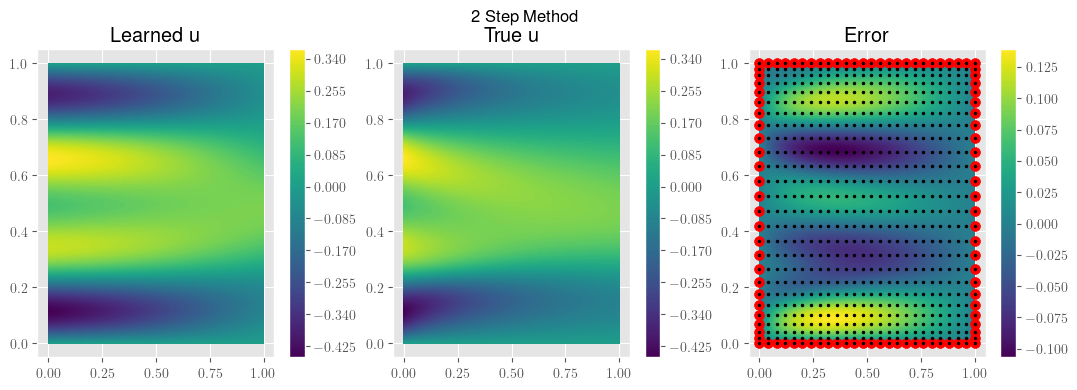

In [8]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results
from plotting import plot_input_data,plot_compare_error

# u_sol = p_adjusted[:u_model.num_params]
# P_sol = p_adjusted[u_model.num_params:]

# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        # "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

# plot_compare_error(
#     tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
# )

plot_compare_error(
    tx_grid_fine,tx_all,tx_obs,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

## Images for the paper

In [9]:
def plot_function(
    obs_points,
    all_points,
    func,
    fine_grid,
    vmin,
    vmax,
    xlabel = '',
    ylabel = '',
    level_sets = 70,
    include_collocation = True,
    include_observations = True
):
    plt.figure(figsize=(5,4))
    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(*fine_grid.T,func(fine_grid),level_sets, vmin = vmin, vmax = vmax)
    # cb = plt.colorbar()
    # tick_locator = ticker.MaxNLocator(nbins=4)
    # cb.locator = tick_locator
    # cb.update_ticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=4)
    plt.tight_layout()
    if include_collocation is True:
        plt.scatter(*all_points.T,c='gray',s = 3,label = "Collocation Point")
    if include_observations is True:
        plt.scatter(*obs_points.T,c='red', s = 50, alpha = 0.5,label = "Function Value Observed")


In [10]:
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

-0.4532077296610373
0.3624836284745666


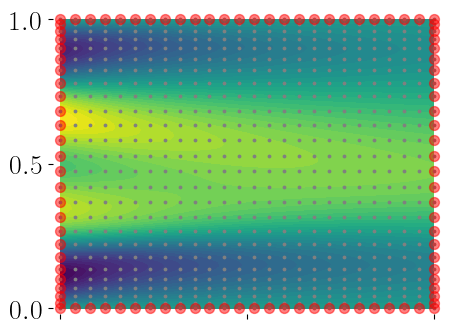

In [11]:
# True
vmin = min(u_true_function(tx_fine))
print(vmin)
vmax = max(u_true_function(tx_fine))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
    level_sets=50,
    vmin=-0.4532246910384856,
    vmax=0.36374402
)
plt.gca().set_xticklabels([]) 
plt.savefig('onlydbry_u_data.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

-0.4532246910384856
0.3627341827377677


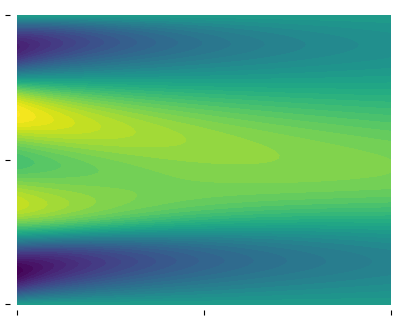

In [67]:
# 1-step
# vmin = min(u_model.point_evaluate(tx_fine,u_sol))
# print(vmin)
# vmax = max(u_model.point_evaluate(tx_fine,u_sol))
# print(vmax)
# plot_function(
#     tx_obs,
#     tx_all,
#     lambda grid_pts: u_model.point_evaluate(grid_pts,u_sol),
#     tx_fine,
#     vmin=-0.4532077296610373,
#     vmax=0.36374402,
#     level_sets=50,
#     include_collocation= False,
#     include_observations= False
# )
# plt.gca().set_xticklabels([]) 
# plt.gca().set_yticklabels([])
# plt.savefig('onlydbry_u_pred_1step.pdf',
#             dpi=300,
#             bbox_inches='tight',
#             format ="pdf"
#             )

-0.4531884310436083
0.36248706777085316


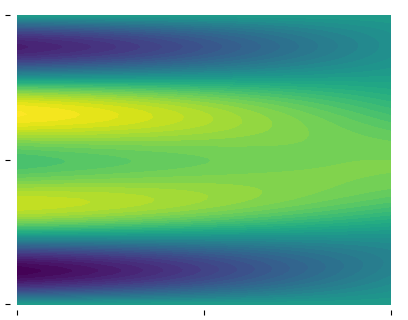

In [12]:
# 2-step
vmin = min(u_model.point_evaluate(tx_fine,u_params_init))
print(vmin)
vmax = max(u_model.point_evaluate(tx_fine,u_params_init))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    lambda grid_pts: u_model.point_evaluate(grid_pts,u_params_init),
    tx_fine,
    level_sets=50,
    vmin = -0.4532077296610373,
    vmax = 0.36374402,
    include_collocation= False,
    include_observations= False
)
plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('onlydbry_u_pred_interp.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

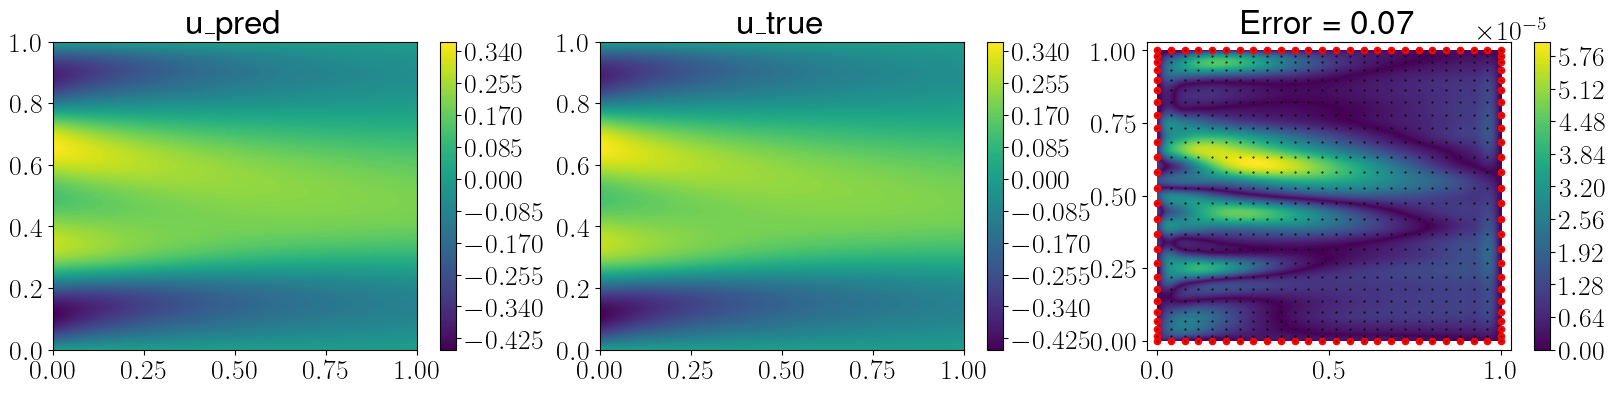

In [69]:
# # Plot results for 1 step
# num_fine_grid = 200
# t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
# tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
# # fig.suptitle('Filtering u')
# pred = u_model.point_evaluate(tx_grid_fine,u_sol)
# # true = data_in_PINNSR[0].flatten()
# true = u_true_function(tx_grid_fine)
# a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
# ax1.set_title('u_pred')
# plt.colorbar(a1, ax = ax1)
# a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
# ax2.set_title('u_true')
# plt.colorbar(a2, ax = ax2)
# a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
# PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,5))
# # ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
# ax3.set_title(f'Error = {jnp.round(PINNSR_err,2)}')
# ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
# ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
# ax3.set_xlim(-0.03,1.03)
# ax3.set_ylim(-0.03,1.03)
# plt.colorbar(a3, ax = ax3)
# plt.savefig('1_step_burgers_bdrydata',dpi = 300)
# plt.show()

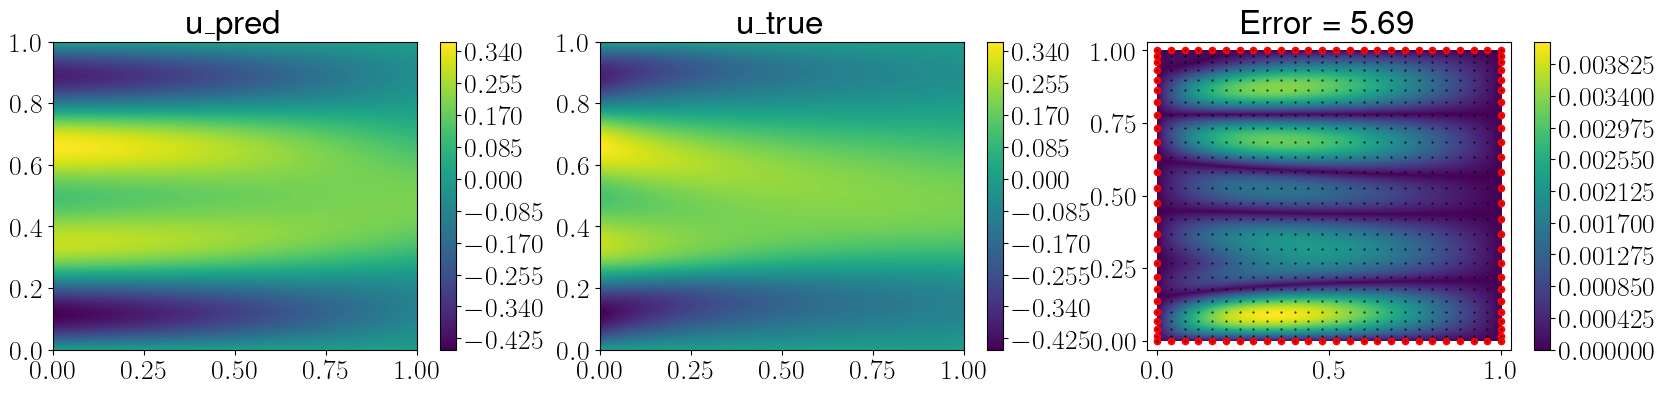

In [13]:
# Plot results for 2 step
num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
# fig.suptitle('2 step method u recovery on Burgers experiment ONLY with boundary data')
pred = u_model.point_evaluate(tx_grid_fine,u_params_init)
# true = data_in_PINNSR[0].flatten()
true = u_true_function(tx_grid_fine)
a1 = ax1.tricontourf(*tx_grid_fine.T,pred,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred - true)/(jnp.linalg.norm(true)),200)
PINNSR_err = jnp.linalg.norm(pred - true,2)/(jnp.linalg.norm(true,5))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(PINNSR_err,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
plt.savefig('2_step_burgers_bdrydata',dpi = 300)
plt.show()

### Testing on new ICs from GP

In [14]:
def new_func_u0(x):
    u0 = -1 * x * np.sin(2 * jnp.pi * x)
    return u0

new_u_true_function,new_ut_true_function,new_interp,t_vals,sols_new = (
    build_burgers_data(func_u0=new_func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:03<00:00, 3015.21it/s]


In [15]:
def get_u_pde_adj(u0_new,method):
    
    # model_grid_features = EqnModel.single_eqn_features(u_model,u_sol,tx_int)
    # Phat of 1 step method
    # @jit
    # def get_pred_ut(input_features):
    #     return P_model.kernel_function(input_features,model_grid_features)@P_sol
    # Phat of 2 step method
    @jit
    def get_pred_ut_2step(input_features):
        init_P_features = EqnModel.single_eqn_features(u_model,u_params_init,tx_int)
        rhs_stacked = EqnModel.stacked_collocation_rhs
        P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
        return P_model.predict_new(input_features,init_P_features,P_params_naive)

    # Observations at ICs and BCs
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])
    new_obs = u0_new(tx_init_bdy) 

    # Set the PDE model
    class PdeModel():
        datafit_weight = 50.
        @jit
        def get_grid_features(u_params):
            evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
            grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
            return jnp.hstack([tx_int,grid_features])
        
        @jit
        def get_grid_target(u_params):
            return u_model.evaluate_operators((dt_k,),tx_int,u_params)
        
        @jit
        def eval_obs_points(u_params):
            return u_model.point_evaluate(tx_init_bdy,u_params)
        
        @jit
        def datafit_residual(u_params):
            obs_preds = PdeModel.eval_obs_points(u_params)
            return new_obs - obs_preds
        
        @jit
        def equation_residual(u_params):
            P_features = PdeModel.get_grid_features(u_params)
            P_model_preds = get_pred_ut_2step(P_features)
            ugrid_target = PdeModel.get_grid_target(u_params)
            return (ugrid_target - P_model_preds)
        
        @jit
        def F(u_params):
            eqn_res = PdeModel.equation_residual(u_params)
            data_res = PdeModel.datafit_residual(u_params)
            return jnp.hstack([
                PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                eqn_res/jnp.sqrt(len(eqn_res))
                ])
        
        jac = jit(jax.jacrev(F))

        def loss(u_params):
            return jnp.linalg.norm(PdeModel.F(u_params))**2
        
        @jit
        def damping_matrix(u_params):
            return u_model.kmat+1e-5 * diagpart(u_model.kmat)

    ## OPTIMIZE

    import Optimizers
    import importlib
    importlib.reload(Optimizers)
    from Optimizers import (
        CholeskyLM,SVD_LM,LMParams,plot_optimization_results
    )

    optParams = LMParams(
        max_iter = 251,init_alpha = 0.05,min_alpha = 1e-16,show_progress=True)

    new_u_init = 0*u_params_init

    u_pde_params,convergence_data = CholeskyLM(
        new_u_init.copy(),
        PdeModel,
        beta = 0.,
        optParams=optParams
    )
    svd_params = LMParams(
        max_iter=201,
        init_alpha=convergence_data.alpha_vals[-1],
        min_alpha=1e-16,print_every=50,
        step_adapt_multiplier=1.6)


    u_pde_params_adj,_ = SVD_LM(u_pde_params,PdeModel,beta = 1e-16,optParams=svd_params)

    return u_pde_params_adj 

In [16]:
# Define grid to test
true = new_u_true_function(tx_grid_fine)
# u_params_newIC_1step = get_u_pde_adj(new_u_true_function,method=1)
# pred1_5 = u_model.point_evaluate(tx_grid_fine,u_params_newIC_1step)

u_params_newIC_2step = get_u_pde_adj(new_u_true_function,method=2)
pred2 = u_model.point_evaluate(tx_grid_fine,u_params_newIC_2step)

# i_opt_1_5 = get_nrmse(true,pred1_5)
i_opt_2 = get_nrmse(true,pred2)

  1%|          | 3/251 [00:17<19:13,  4.65s/it]  

Iteration 0, loss = 1.992e-07, gradnorm = 139.8, alpha = 0.04167, improvement_ratio = 1.0
Iteration 1, loss = 8.121e-08, gradnorm = 2.892e-06, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 5.368e-08, gradnorm = 5.598e-07, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 4.167e-08, gradnorm = 3.134e-07, alpha = 0.02411, improvement_ratio = 1.0


  3%|▎         | 8/251 [00:18<04:30,  1.11s/it]

Iteration 4, loss = 3.405e-08, gradnorm = 2.036e-07, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 2.825e-08, gradnorm = 1.492e-07, alpha = 0.01674, improvement_ratio = 1.0


  0%|          | 1/201 [00:16<54:02, 16.21s/it]

Iteration 0, loss = 1.688e-09, gradnorm = 1.067e-08, alpha = 0.0004717, improvement_ratio = 1.006


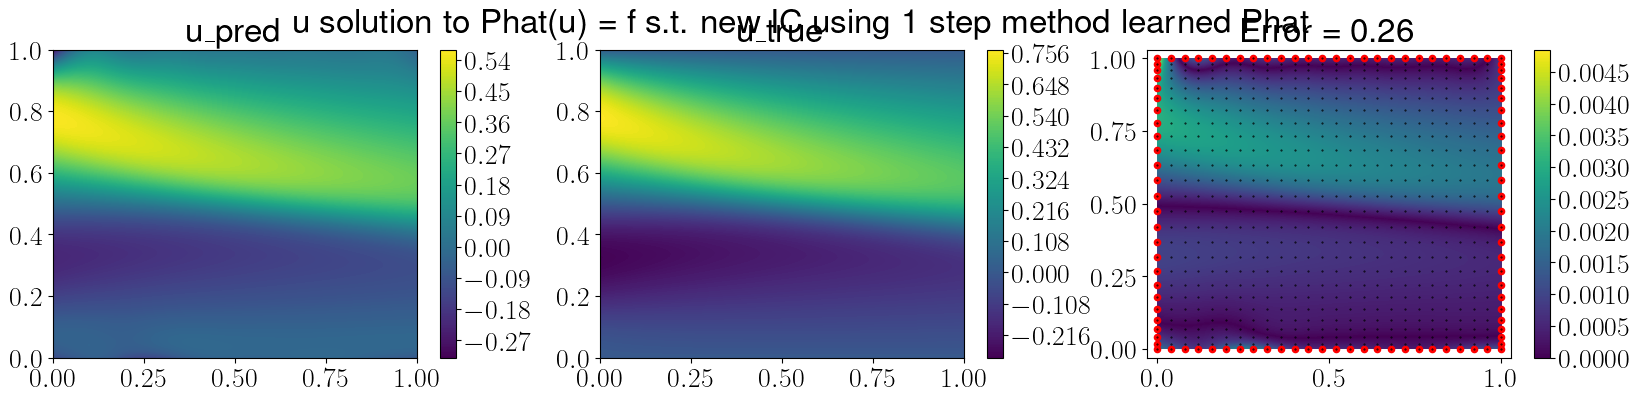

In [74]:
# # Plot results for 1 step operator learning error
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
# fig.suptitle('u solution to Phat(u) = f s.t. new IC using 1 step method learned Phat')
# a1 = ax1.tricontourf(*tx_grid_fine.T,pred1_5,200)
# ax1.set_title('u_pred')
# plt.colorbar(a1, ax = ax1)
# a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
# ax2.set_title('u_true')
# plt.colorbar(a2, ax = ax2)
# a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred1_5 - true)/(jnp.linalg.norm(true)),200)
# err_1_step = jnp.linalg.norm(pred1_5 - true,2)/(jnp.linalg.norm(true,2))
# # ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
# ax3.set_title(f'Error = {jnp.round(err_1_step,2)}')
# ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
# ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
# ax3.set_xlim(-0.03,1.03)
# ax3.set_ylim(-0.03,1.03)
# plt.colorbar(a3, ax = ax3)
# # plt.savefig('1_step_initial_final_operator_prediction',dpi = 300)
# plt.show()

-0.2896012968704471
0.7661834960783577


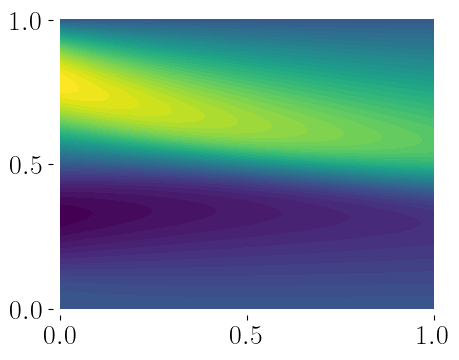

In [17]:
# True with new IC
vmin = min(new_u_true_function(tx_grid_fine))
print(vmin)
vmax = max(new_u_true_function(tx_grid_fine))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    new_u_true_function,
    tx_grid_fine,
    level_sets=50,
    vmin=vmin,
    vmax=vmax,
    include_collocation= False,
    include_observations=False
)
# plt.gca().set_xticklabels([]) 
plt.savefig('onlydbry_newIC_u_data.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

-0.31847804854623973
0.565102226799354


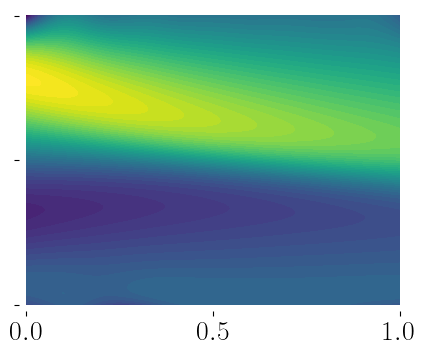

In [76]:
# # 1step- with new IC
# vmin = min(u_model.point_evaluate(tx_grid_fine,u_params_newIC_1step))
# print(vmin)
# vmax = max(u_model.point_evaluate(tx_grid_fine,u_params_newIC_1step))
# print(vmax)
# plot_function(
#     tx_obs,
#     tx_all,
#     lambda grid: u_model.point_evaluate(grid,u_params_newIC_1step),
#     tx_grid_fine,
#     level_sets=50,
#     vmin=vmin,
#     vmax=vmax,
#     include_collocation= False,
#     include_observations=False
# )
# plt.gca().set_yticklabels([]) 
# plt.savefig('onlydbry_newIC_u_pred_1step.pdf',
#             dpi=300,
#             bbox_inches='tight',
#             format ="pdf"
#             )

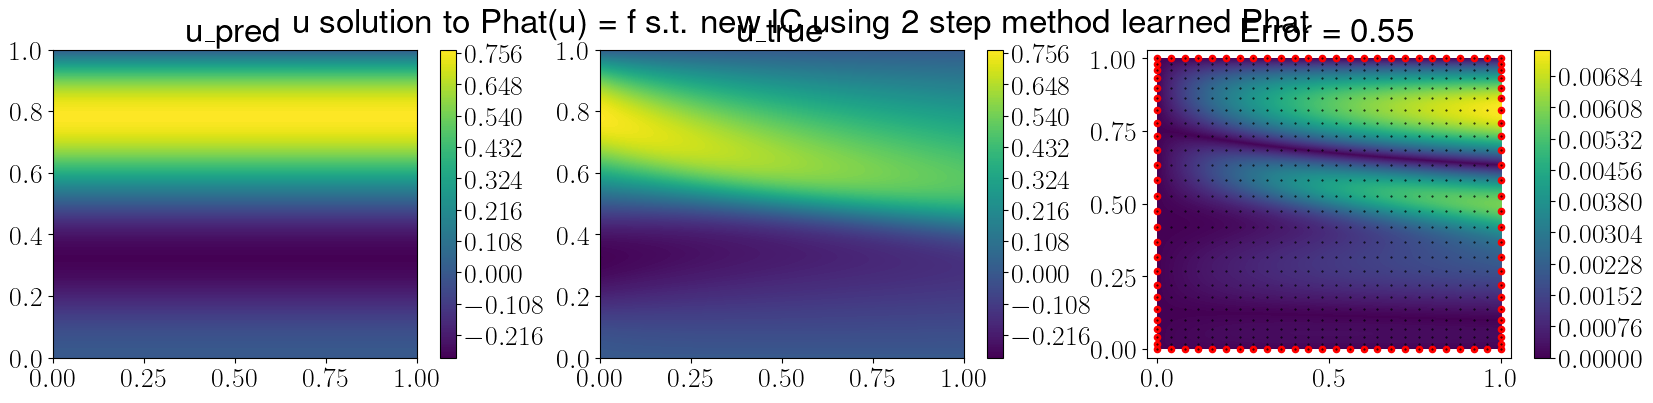

In [18]:
# Plot results for 2 step operator learning error
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,4))
fig.suptitle('u solution to Phat(u) = f s.t. new IC using 2 step method learned Phat')
a1 = ax1.tricontourf(*tx_grid_fine.T,pred2,200)
ax1.set_title('u_pred')
plt.colorbar(a1, ax = ax1)
a2 = ax2.tricontourf(*tx_grid_fine.T,true,200)
ax2.set_title('u_true')
plt.colorbar(a2, ax = ax2)
a3 = ax3.tricontourf(*tx_grid_fine.T,jnp.abs(pred2 - true)/(jnp.linalg.norm(true)),200)
err_2_step = jnp.linalg.norm(pred2 - true,2)/(jnp.linalg.norm(true,2))
# ax3.set_title(f'norm(pred - true)/norm(true) = {jnp.round(PINNSR_err,2)}')
ax3.set_title(f'Error = {jnp.round(err_2_step,2)}')
ax3.scatter(*tx_obs.T, c = 'red', s = 20, )
ax3.scatter(*tx_all.T, c = 'black', s = 0.2)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)
plt.colorbar(a3, ax = ax3)
# plt.savefig('1_step_initial_final_operator_prediction',dpi = 300)
plt.show()

-0.2896122172323885
0.766259946354694


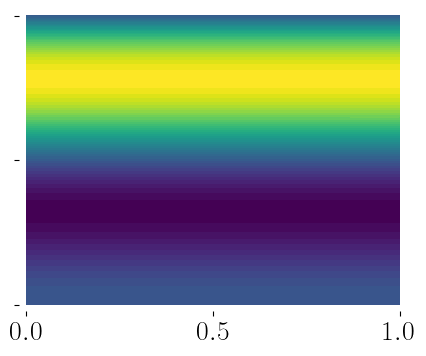

In [19]:
# 2 step- with new IC
vmin = min(u_model.point_evaluate(tx_grid_fine,u_params_newIC_2step))
print(vmin)
vmax = max(u_model.point_evaluate(tx_grid_fine,u_params_newIC_2step))
print(vmax)
plot_function(
    tx_obs,
    tx_all,
    lambda grid: u_model.point_evaluate(grid,u_params_newIC_2step),
    tx_grid_fine,
    level_sets=50,
    vmin=vmin,
    vmax=vmax,
    include_collocation= False,
    include_observations=False
)
plt.gca().set_yticklabels([]) 
plt.savefig('onlydbry_newIC_u_pred_2step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )